# Google Colab / Kaggle / PC

In [1]:
mode = "Colab"

In [2]:
import os

if mode == "Colab":
    from google.colab import drive
    drive.mount('/content/gdrive')
    os.chdir("/content/gdrive/My Drive/FPL_ML")
    TRAIN_PATH = "data/final_dataset.csv"
if mode == "PC":
    os.chdir("D:\PulpitE\FPL_ML")
    TRAIN_PATH = "data/final_dataset.csv"
if mode == "Kaggle":
    TRAIN_PATH = "/kaggle/input/fpl-dataset/final_dataset.csv"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Imports

In [3]:
import pandas as pd

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms
from torchvision.transforms import ToTensor

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import matplotlib.pyplot as plt

import numpy as np
import random

# Constants and seeds

In [4]:
# FIXTURES_IN_SAMPLE
FIS = 8

# FIXTURES_FOR_PLAYER - number of gameweeks required
FFP = 15

NEXT_GAMEWEEK = 19

In [5]:
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_all_seeds(42)

# Device

In [6]:
device = torch.device("cuda")
# device = torch.device('mps')
# device = torch.device('cpu')

# Getting data and choosing features

In [7]:
df = pd.read_csv('data/final_dataset.csv')

In [8]:
# remembering original dataframes
df_original = df

df_gk_original = df[df["FPL position"] == "GK"]
df_def_original = df[df["FPL position"] == "DEF"]
df_mid_original = df[df["FPL position"] == "MID"]
df_fwd_original = df[df["FPL position"] == "FWD"]

In [9]:
df_original.columns

Index(['Unnamed: 0', 'Date', 'Day', 'Comp', 'Round', 'Venue', 'Squad',
       'Opponent', 'Start', 'Pos', 'Min', 'Gls', 'Ast', 'PK', 'PKatt', 'Sh',
       'SoT', 'CrdY', 'CrdR', 'Touches', 'Tkl', 'Int', 'Blocks', 'xG', 'npxG',
       'xAG', 'SCA', 'GCA', 'Cmp', 'Att', 'Cmp%', 'PrgP', 'Carries', 'PrgC',
       'Att.1', 'Succ', 'Match Report', 'Name', 'Season', 'WDL', 'GoalsTeams',
       'Team Score', 'Opp Score', 'CS', 'Was Home', 'GW', 'FPL',
       'neutral_name', 'Total Points', 'FPL position', 'Opp rating',
       'ScoreForLast5', 'ScoreAgainstLast5'],
      dtype='object')

In [10]:
df_original[df_original["Name"] == "Erling-Haaland"]

,Unnamed: 0,Date,Day,Comp,Round,Venue,Squad,Opponent,Start,Pos,...,CS,Was Home,GW,FPL,neutral_name,Total Points,FPL position,Opp rating,ScoreForLast5,ScoreAgainstLast5
2886,2886,2022-08-07,Sun,Premier League,Matchweek 1,Away,Manchester City,West Ham,Y,FW,...,1.0,0.0,1,13.0,Erling-Haaland,13.0,FWD,1783.215088,1.80,2.80
2887,2887,2022-08-13,Sat,Premier League,Matchweek 2,Home,Manchester City,Bournemouth,Y,FW,...,1.0,1.0,2,6.0,Erling-Haaland,5.0,FWD,1644.115601,2.00,0.00
2888,2888,2022-08-21,Sun,Premier League,Matchweek 3,Away,Manchester City,Newcastle Utd,Y,FW,...,0.0,0.0,3,7.0,Erling-Haaland,6.0,FWD,1764.226318,3.00,0.00
2889,2889,2022-08-27,Sat,Premier League,Matchweek 4,Home,Manchester City,Crystal Palace,Y,FW,...,0.0,1.0,4,17.0,Erling-Haaland,17.0,FWD,1761.431274,3.00,1.00
2890,2890,2022-08-31,Wed,Premier League,Matchweek 5,Home,Manchester City,Nott'ham Forest,Y,FW,...,1.0,1.0,5,18.0,Erling-Haaland,17.0,FWD,1617.610229,3.25,1.25
2891,2891,2022-09-03,Sat,Premier League,Matchweek 6,Away,Manchester City,Aston Villa,Y,FW,...,0.0,0.0,6,7.0,Erling-Haaland,9.0,FWD,1713.250488,3.80,1.00
2892,2892,2022-09-17,Sat,Premier League,Matchweek 8,Away,Manchester City,Wolves,Y,FW,...,1.0,0.0,8,8.0,Erling-Haaland,6.0,FWD,1708.179321,3.60,1.20
2893,2893,2022-10-02,Sun,Premier League,Matchweek 9,Home,Manchester City,Manchester Utd,Y,FW,...,0.0,1.0,9,23.0,Erling-Haaland,23.0,FWD,1806.035278,3.40,1.20
2894,2894,2022-10-08,Sat,Premier League,Matchweek 10,Home,Manchester City,Southampton,Y,FW,...,1.0,1.0,10,8.0,Erling-Haaland,6.0,FWD,1662.400391,4.00,1.20
2895,2895,2022-10-16,Sun,Premier League,Matchweek 11,Away,Manchester City,Liverpool,Y,FW,...,0.0,0.0,11,2.0,Erling-Haaland,2.0,FWD,1989.153687,4.00,0.80


In [11]:
info = ["Name", "GW", "FPL position"]
other = ["LSTM"]
features = ["Min", "Gls", "Ast", "Sh", "SoT", "xG", "npxG", "xAG", "SCA", "GCA", "CS", "CrdY", "CrdR", "Opp rating", "Team Score", "Opp Score", "Was Home"]
to_predict = ["Total Points"]

In [12]:
df = df[info + features + to_predict]
df[features + to_predict] = df[features + to_predict].astype("float32")

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [13]:
df.shape

(7457, 21)

In [14]:
# removing NaN rows and players that appear less than 15 times
df = df.dropna()
grouped = df.groupby('Name')

# taking onyl players with at least FFP matches in logs
df = grouped.filter(lambda x: len(x) >= FFP)

In [15]:
df.shape

(5771, 21)

In [16]:
df.head(20)

,Name,GW,FPL position,Min,Gls,Ast,Sh,SoT,xG,npxG,...,SCA,GCA,CS,CrdY,CrdR,Opp rating,Team Score,Opp Score,Was Home,Total Points
0,Brenden-Aaronson,1,MID,83.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1725.276489,2.0,1.0,1.0,2.0
1,Brenden-Aaronson,2,MID,90.0,0.0,0.0,2.0,0.0,0.1,0.1,...,4.0,0.0,0.0,1.0,0.0,1667.049927,2.0,2.0,0.0,1.0
2,Brenden-Aaronson,3,MID,82.0,1.0,0.0,2.0,2.0,1.0,1.0,...,5.0,1.0,1.0,0.0,0.0,1901.388306,3.0,0.0,1.0,8.0
3,Brenden-Aaronson,4,MID,81.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,1.0,0.0,1783.540161,0.0,1.0,0.0,1.0
4,Brenden-Aaronson,5,MID,75.0,0.0,1.0,1.0,1.0,0.1,0.1,...,4.0,1.0,0.0,0.0,0.0,1688.922485,1.0,1.0,1.0,5.0
5,Brenden-Aaronson,6,MID,90.0,0.0,0.0,1.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,1727.113647,2.0,5.0,0.0,2.0
6,Brenden-Aaronson,9,MID,78.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,1.0,0.0,0.0,1716.016846,0.0,0.0,1.0,3.0
7,Brenden-Aaronson,10,MID,75.0,0.0,0.0,2.0,0.0,0.1,0.1,...,3.0,1.0,0.0,0.0,0.0,1748.905396,1.0,2.0,0.0,5.0
8,Brenden-Aaronson,11,MID,90.0,0.0,0.0,2.0,1.0,0.1,0.1,...,4.0,0.0,0.0,0.0,0.0,1908.041016,0.0,1.0,1.0,2.0
9,Brenden-Aaronson,12,MID,90.0,0.0,0.0,1.0,0.0,0.1,0.1,...,3.0,0.0,0.0,0.0,0.0,1730.854736,0.0,2.0,0.0,2.0


In [17]:
last_names = df["Name"].unique()

In [18]:
df.columns

Index(['Name', 'GW', 'FPL position', 'Min', 'Gls', 'Ast', 'Sh', 'SoT', 'xG',
       'npxG', 'xAG', 'SCA', 'GCA', 'CS', 'CrdY', 'CrdR', 'Opp rating',
       'Team Score', 'Opp Score', 'Was Home', 'Total Points'],
      dtype='object')

In [19]:
df["FPL position"].unique()

array(['MID', 'FWD', 'DEF', 'GK'], dtype=object)

# DF to DataLoader

In [20]:
# gk, def, mid, fwd
df_gk = df[df["FPL position"] == "GK"]
df_def = df[df["FPL position"] == "DEF"]
df_mid = df[df["FPL position"] == "MID"]
df_fwd = df[df["FPL position"] == "FWD"]

In [21]:
df_gk.iloc[0]

Name                Alisson
GW                        1
FPL position             GK
Min                    90.0
Gls                     0.0
Ast                     0.0
Sh                      0.0
SoT                     0.0
xG                      0.0
npxG                    0.0
xAG                     0.0
SCA                     0.0
GCA                     0.0
CS                      0.0
CrdY                    0.0
CrdR                    0.0
Opp rating      1636.164673
Team Score              2.0
Opp Score               2.0
Was Home                0.0
Total Points            1.0
Name: 196, dtype: object

In [22]:
df.shape

(5771, 21)

In [23]:
def init_index_table(df):
    names = df["Name"].unique()
    result_dict = {}
    
    current_index = 0
    player_index = 0
    
    for name in names:
        sample_index = 0
        samples_for_names = df[df["Name"] == name].shape[0] - FIS
        for i in range(samples_for_names):
            result_dict[current_index] = [player_index, sample_index]
            current_index += 1
            sample_index += 1
        player_index += 1
    
    return result_dict

In [24]:
class PandasDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.names = dataframe["Name"].unique()
        self.index_table = init_index_table(dataframe)
        self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

    def __len__(self):
        length = 0
        for name in self.names:
            length += (self.dataframe[self.dataframe["Name"] == name].shape[0] - FIS)
        return length

    def __getitem__(self, idx):
        # print(idx)
        player_id, sample_id = self.index_table[idx]
        name = self.names[player_id]
        # print(name)
        features = self.dataframe[self.dataframe["Name"] == name]
        # print(self.dataframe[self.dataframe["Name"] == name])
        # print(features[sample_id: (sample_id + 4)])
        features = features[sample_id: (sample_id + FIS)].drop(columns=info).values[:, :-1]
        # print(features)
        # print(features)
        # print(type(features))
        # print(self.dataframe[self.dataframe["Name"] == name].values[:, -1])
        # print(type(self.dataframe[self.dataframe["Name"] == name].values[:, -1]))
        # target = self.dataframe[self.dataframe["Name"] == name].values[:, -1]
        # target = target.astype(np.float32)
        # target = torch.from_numpy(target)
        target = np.float32(self.dataframe[self.dataframe["Name"] == name].values[(sample_id + FIS), -1])
        # print(name, idx, target, sample_id)
        # print(type(target))
        return features, target

In [25]:
# df[["Name", "FPL position"]].drop_duplicates().head(20)

In [26]:
dataset = PandasDataset(df)
dataset_gk = PandasDataset(df_gk)
dataset_def = PandasDataset(df_def)
dataset_mid = PandasDataset(df_mid)
dataset_fwd = PandasDataset(df_fwd)

In [27]:
# dataset.__getitem__(0)

In [28]:
# dataset_fwd.__getitem__(10)

In [29]:
dataset_gk.__len__()

305

In [30]:
dataset_def.__len__()

1137

In [31]:
dataset_mid.__len__()

1469

In [32]:
dataset_fwd.__len__()

356

In [33]:
batch_size = 16

In [34]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
dataloader_gk = DataLoader(dataset_gk, batch_size=batch_size, shuffle=False)
dataloader_def = DataLoader(dataset_def, batch_size=batch_size, shuffle=False)
dataloader_mid = DataLoader(dataset_mid, batch_size=batch_size, shuffle=False)
dataloader_fwd = DataLoader(dataset_fwd, batch_size=batch_size, shuffle=False)

In [38]:
len(dataloader), len(dataloader_gk), len(dataloader_def), len(dataloader_mid), len(dataloader_fwd)

205

In [35]:
# next(iter(dataloader_mid))

In [36]:
# next(iter(dataloader))[1]

# LSTM Model

In [37]:
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMNetwork, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.transpose(x, 0, 1)
        # x = x.view(-1, batch_size)
        # x = torch.transpose(x, 0, 1)
        # print("FOR", x.shape)
        # print(x.shape)
        # print(x.shape)
        out, _ = self.lstm(x)
        # print(out.shape)
        out = self.fc(out[-1])
        return out

# Training loops

In [39]:
criterion = nn.MSELoss()

In [40]:
def train_net(net, num_epochs, dataloader, optimizer):
    loss_history = []
    for epoch in range(num_epochs):
        running_loss = 0
        for i, (inputs, targets) in enumerate(dataloader):
            inputs = torch.flatten(inputs, 1, 2)
            inputs = inputs.unsqueeze(2).to(device)
            targets = targets.to(device)
            # print("INPUTS", inputs.shape)
            # print("TARGETS", targets.shape)
            # print(targets)
            optimizer.zero_grad()
            outputs = net(inputs).flatten().to(device)
            # print("OUTPUTS", outputs.shape)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()

        loss_history.append(running_loss / len(dataloader))
        if epoch % 5 == 0:
            print(f'Epoch {epoch} Loss: {running_loss / len(dataloader)}')
    
    return loss_history

In [41]:
def plot_loss_history(loss_history):
    plt.plot(loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

## Training loop - general net

In [42]:
%%time
net = LSTMNetwork(1, 20, 2, 1, dropout=0.4).to(device)
optimizer = optim.Adam(net.parameters(), lr=0.005)
loss_history = train_net(net, 30, dataloader, optimizer)

Epoch 0 Loss: 9.007537005296568
Epoch 5 Loss: 8.788723100103983
Epoch 10 Loss: 8.78108821031524
Epoch 15 Loss: 8.777838995980053
Epoch 20 Loss: 8.77909851423124
Epoch 25 Loss: 8.776847212489058
CPU times: user 3min 58s, sys: 4.07 s, total: 4min 2s
Wall time: 4min 21s


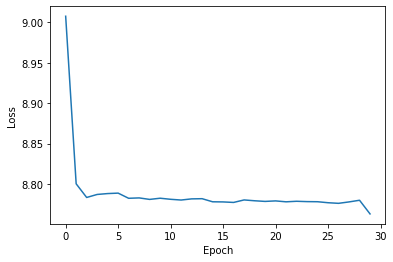

In [43]:
plot_loss_history(loss_history)

## Training loop - goalkeeper net

In [44]:
net_gk = LSTMNetwork(1, 20, 2, 1, dropout=0.4).to(device)

In [45]:
%%time
optimizer_gk = optim.Adam(net_gk.parameters(), lr=0.01)
loss_history_gk = train_net(net_gk, 5, dataloader_gk, optimizer_gk)

Epoch 0 Loss: 13.581346929073334
CPU times: user 3.18 s, sys: 19.3 ms, total: 3.2 s
Wall time: 3.3 s


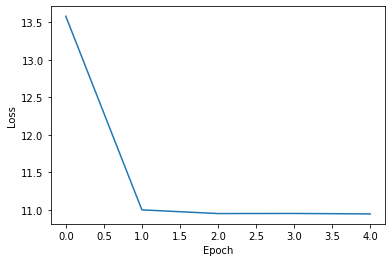

In [46]:
plot_loss_history(loss_history_gk)

## Training loop - defender net

In [47]:
net_def = LSTMNetwork(1, 20, 2, 1, dropout=0.4).to(device)

In [48]:
%%time
optimizer_def = optim.Adam(net_def.parameters(), lr=0.005)
loss_history_def = train_net(net_def, 5, dataloader_def, optimizer_def)

Epoch 0 Loss: 9.611619954514834
CPU times: user 10 s, sys: 109 ms, total: 10.2 s
Wall time: 10.7 s


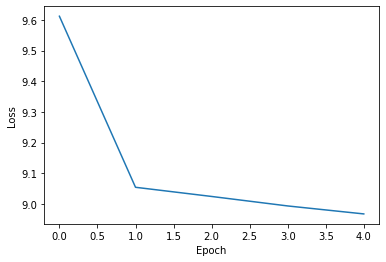

In [49]:
plot_loss_history(loss_history_def)

## Training loop - midfielder net

In [50]:
net_mid = LSTMNetwork(1, 20, 2, 1, dropout=0.4).to(device)

In [51]:
%%time
optimizer_mid = optim.Adam(net_mid.parameters(), lr=0.005)
loss_history_mid = train_net(net_mid, 10, dataloader_mid, optimizer_mid)

Epoch 0 Loss: 8.964587155891502
Epoch 5 Loss: 8.268603083880052
Epoch 10 Loss: 8.267747240222018
Epoch 15 Loss: 8.264255325431408
Epoch 20 Loss: 8.266433663990187
Epoch 25 Loss: 8.261217414037041
Epoch 30 Loss: 8.263434578543125
Epoch 35 Loss: 8.265538971061291
Epoch 40 Loss: 8.262768155854681
Epoch 45 Loss: 8.26443356923435
Epoch 50 Loss: 8.259500916885292
Epoch 55 Loss: 8.254011837036714
Epoch 60 Loss: 7.912750645824101
Epoch 65 Loss: 7.931277031483858
Epoch 70 Loss: 7.923843623503394
Epoch 75 Loss: 7.924104962659919
Epoch 80 Loss: 7.9249878733054455
Epoch 85 Loss: 7.926537284384603
Epoch 90 Loss: 7.92513108253479
Epoch 95 Loss: 7.9238073929496435
CPU times: user 4min 41s, sys: 2.77 s, total: 4min 44s
Wall time: 4min 45s


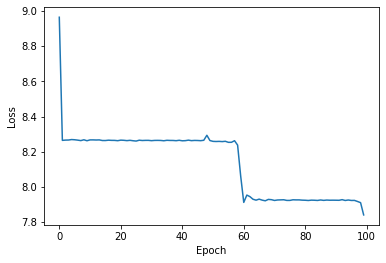

In [52]:
plot_loss_history(loss_history_mid)

## Training loop - forward net

In [84]:
net_fwd = LSTMNetwork(1, 10, 2, 1, dropout=0.6).to(device)

In [85]:
%%time
optimizer_fwd = optim.Adam(net_fwd.parameters(), lr=0.005)
loss_history_fwd = train_net(net_fwd, 500, dataloader_fwd, optimizer_fwd)

Epoch 0 Loss: 14.301313538914142
Epoch 5 Loss: 10.61626851040384
Epoch 10 Loss: 10.63194665701493
Epoch 15 Loss: 10.616363281789033
Epoch 20 Loss: 10.592920914940212
Epoch 25 Loss: 10.592827454857204
Epoch 30 Loss: 10.643749257792598
Epoch 35 Loss: 10.633854352909585
Epoch 40 Loss: 10.601390999296438
Epoch 45 Loss: 10.626073318979014
Epoch 50 Loss: 10.613361814747686
Epoch 55 Loss: 10.655755887860836
Epoch 60 Loss: 10.591164516366046
Epoch 65 Loss: 10.603979815607486
Epoch 70 Loss: 10.630406151647152
Epoch 75 Loss: 10.597906112670898
Epoch 80 Loss: 10.633610176003497
Epoch 85 Loss: 10.615477199139802
Epoch 90 Loss: 10.605405869691268
Epoch 95 Loss: 10.608668493187945
Epoch 100 Loss: 10.625430884568587
Epoch 105 Loss: 10.597709412160127
Epoch 110 Loss: 10.707183122634888
Epoch 115 Loss: 10.558500694191974
Epoch 120 Loss: 10.198821684588557
Epoch 125 Loss: 9.966791948546534
Epoch 130 Loss: 9.383254896039547
Epoch 135 Loss: 9.339854090110116
Epoch 140 Loss: 9.026188961837603
Epoch 145 Los

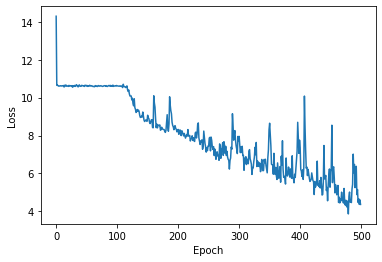

In [86]:
plot_loss_history(loss_history_fwd)

# Metrics

In [56]:
# general model


# Saving models to files

In [57]:
# general model
torch.save(net.state_dict(), 'models/lstm_general.pt')

# positional models
torch.save(net_gk.state_dict(), 'models/lstm_gk.pt')
torch.save(net_def.state_dict(), 'models/lstm_def.pt')
torch.save(net_mid.state_dict(), 'models/lstm_mid.pt')
torch.save(net_fwd.state_dict(), 'models/lstm_fwd.pt')

# Predictions - general model

In [60]:
def generate_predictions(dataloader_pos, dataset_pos, net_pos, df_original):
    index = 0
    predictions_pos = []
    for inputs, target in dataloader_pos:
        inputs = torch.flatten(inputs, 1, 2)
        inputs = inputs.unsqueeze(2).to(device)
        # print("INPUTS", inputs)
        # print(inputs)
        outputs = net_pos(inputs).to(device)
        # print("OUTPUTS", outputs)
        for output in outputs:
            player_id, sample_id = dataset_pos.index_table[index]
            name = dataset_pos.names[player_id]
            points = round(output.item(), 2)
            df_row = df_original[df_original["Name"] == name].iloc[sample_id + FIS]
            df_row["Points"] = points
            df_gw = df_row["GW"]
            df_opp = df_row["Opponent"]
            
            gw = sample_id + FIS + 1 # wrong
            predictions_pos.append(df_row)
            # df.loc[(df["Name"] == name) & (df["GW"] == gw), "LSTM"] = points
            index += 1
    
    output_df = pd.DataFrame(predictions_pos)
    output_df = output_df.loc[:, ~output_df.columns.str.contains('^Unnamed')]
    return output_df

In [64]:
prediction_columns = ["Name", "GW", "Opponent", "Was Home", "Total Points", "Points"]

In [65]:
predictions = generate_predictions(dataloader, dataset, net, df_original)

In [66]:
predictions.sort_values(by=["Points"], ascending = False).head(20)[prediction_columns]

,Name,GW,Opponent,Was Home,Total Points,Points
8,Brenden-Aaronson,11,Arsenal,1.0,2.0,2.8
3465,Mathias-Jorgensen,21,Leeds United,0.0,0.0,2.8
3581,Max-Kilman,18,Manchester Utd,1.0,2.0,2.8
3574,Max-Kilman,11,Nott'ham Forest,1.0,6.0,2.8
3547,Thilo-Kehrer,20,Wolves,0.0,0.0,2.8
3546,Thilo-Kehrer,19,Leeds United,0.0,1.0,2.8
3512,Michael-Keane,10,Manchester Utd,1.0,0.0,2.8
3500,Harry-Kane,7,Manchester City,0.0,5.0,2.8
3494,Harry-Kane,15,Liverpool,1.0,8.0,2.8
3489,Harry-Kane,10,Brighton,0.0,7.0,2.8


In [67]:
# # appending results to original df
# for df_gw, df_opp, name, gw, points in predictions:
#     df_original.loc[(df_original["Name"] == name) & (df["GW"] == gw), "LSTM"] = points

In [68]:
# df_original.to_csv("data/fpl_fbref_elo_lstm.csv")

# Predictions for each position

## Goalkeepers

In [69]:
predictions_gk = generate_predictions(dataloader_gk, dataset_gk, net_gk, df_gk_original)

In [70]:
# results sorted
predictions_gk.sort_values(by=["Points"], ascending = False).head(20)[prediction_columns]

,Name,GW,Opponent,Was Home,Total Points,Points
5714,Marek-Rodak,11,Bournemouth,1.0,0.0,3.08
4325,Emiliano-Martinez,10,Nott'ham Forest,0.0,2.0,3.07
213,Alisson,20,Brighton,0.0,2.0,3.07
5056,Robin-Olsen,11,Chelsea,1.0,0.0,3.07
5065,Robin-Olsen,20,Leeds United,1.0,0.0,3.07
6750,Mark-Travers,10,Leicester City,1.0,0.0,3.07
458,Kepa-Arrizabalaga,11,Aston Villa,0.0,10.0,3.07
2046,Ederson,7,Tottenham,1.0,1.0,3.07
3852,Bernd-Leno,12,Aston Villa,1.0,11.0,3.07
6753,Mark-Travers,13,West Ham,0.0,1.0,3.07


## Defenders

In [71]:
predictions_def = generate_predictions(dataloader_def, dataset_def, net_def, df_def_original)

In [72]:
# results sorted
predictions_def.sort_values(by=["Points"], ascending = False).head(20)[prediction_columns]

,Name,GW,Opponent,Was Home,Total Points,Points
101,Rayan-Ait-Nouri,21,Manchester City,0.0,1.0,2.44
4678,Tyrick-Mitchell,13,Everton,0.0,1.0,2.44
6611,Luke-Thomas,16,West Ham,0.0,6.0,2.43
5988,Davinson-Sanchez,18,Aston Villa,1.0,0.0,2.43
866,Sven-Botman,18,Leeds United,1.0,6.0,2.42
7041,Joel-Ward,13,Everton,0.0,1.0,2.42
1810,Eric-Dier,11,Everton,1.0,6.0,2.42
6648,Kieran-Tierney,14,Nott'ham Forest,1.0,1.0,2.42
3802,Jamaal-Lascelles,17,Leicester City,0.0,0.0,2.42
6457,John-Stones,16,Brentford,1.0,1.0,2.42


## Midfielders

In [73]:
predictions_mid = generate_predictions(dataloader_mid, dataset_mid, net_mid, df_mid_original)

In [74]:
# results sorted
predictions_mid.sort_values(by=["Points"], ascending = False).head(20)[prediction_columns]

,Name,GW,Opponent,Was Home,Total Points,Points
8,Brenden-Aaronson,11,Arsenal,1.0,2.0,3.04
4306,Martinelli,10,Liverpool,1.0,12.0,3.04
4315,Martinelli,20,Tottenham,0.0,2.0,3.04
4314,Martinelli,19,Newcastle Utd,1.0,3.0,3.04
4313,Martinelli,18,Brighton,0.0,10.0,3.04
4310,Martinelli,15,Chelsea,0.0,3.0,3.04
4309,Martinelli,14,Nott'ham Forest,1.0,8.0,3.04
4308,Martinelli,13,Southampton,0.0,2.0,3.04
4307,Martinelli,11,Leeds United,0.0,3.0,3.04
4263,Solly-March,21,Leicester City,0.0,2.0,3.04


## Forwards

In [87]:
predictions_fwd = generate_predictions(dataloader_fwd, dataset_fwd, net_fwd, df_fwd_original)

In [88]:
# results sorted
predictions_fwd.sort_values(by=["Points"], ascending = False).head(20)[prediction_columns]

,Name,GW,Opponent,Was Home,Total Points,Points
7206,Callum-Wilson,14,Aston Villa,1.0,19.0,17.50
2904,Erling-Haaland,21,Wolves,1.0,17.0,16.78
2899,Erling-Haaland,17,Leeds United,0.0,13.0,14.66
4714,Aleksandar-Mitrovic,17,Crystal Palace,0.0,15.0,13.95
3490,Harry-Kane,11,Everton,1.0,9.0,13.93
2896,Erling-Haaland,13,Brighton,1.0,13.0,13.26
7089,Ollie-Watkins,21,Southampton,0.0,8.0,12.60
3498,Harry-Kane,19,Crystal Palace,0.0,16.0,11.46
6710,Ivan-Toney,16,Manchester City,0.0,13.0,10.97
4710,Aleksandar-Mitrovic,11,Bournemouth,1.0,7.0,10.86
